In [3]:
import time
import nltk
import string
import pronouncing
import numpy as np
from HMM import unsupervised_HMM
import nltk
import string
import pronouncing
import numpy as np
import random
with open('./project2data/shakespeare.txt', 'r') as file1: 
    poems_elements = file1.read().splitlines() 

In [6]:
# to prove that the stress output is consistent with the syllable of each word
for i in range(len(total_words_list)):
    if len(stress(i)) != total_words_syllable_list[i]:
        print('Error!: the stress and syllable do not match!')

In [69]:
#use 
#make sure 10 syllables in total
#make sure the sentence follow unstressed stress pattern
def generate_sequence(last_word_index, A_matrix, O_matrix, word_list, word_syllable_list):
    sequence_logprob = 0
    syllable = word_syllable_list[last_word_index]
    # the stress that the previous word should end with
    end_stress = (int(stress(last_word_index)[0])+1)%2
    L = len(A_matrix)
    D = len(O_matrix[0])
    #HMM current state
    prob = O_matrix[:,last_word_index]/np.sum(O_matrix[:,last_word_index])
    Y_curr = np.random.choice(np.arange(L), p = prob)
    
    #the probability of getting Y for first position
    sequence_logprob = sequence_logprob + np.log(prob[Y_curr])
    #HMM next state
    Y_prev = None
    # the index of current X in word_list
    X_curr = None
    # the output sequence of index in word list 
    numerical_emission = [last_word_index]
    # the output sequence of word
    word_emission = [word_list[last_word_index]]
    while syllable < 10:
        Y_prev = np.random.choice(np.arange(L), p = A_matrix[Y_curr])
        sequence_logprob = sequence_logprob +  np.log(A_matrix[Y_curr][Y_prev])
        Y_curr = Y_prev
        possible_X_curr = possible_word_index_with_end_stress(end_stress)
        X_curr = np.random.choice(possible_X_curr, p = O_matrix[Y_curr, possible_X_curr]/np.sum(O_matrix[Y_curr, possible_X_curr]))
        sequence_logprob = sequence_logprob + np.log(O_matrix[Y_curr, X_curr])
        numerical_emission.insert(0,X_curr)
        word_emission.insert(0,word_list[X_curr])
        syllable += word_syllable_list[X_curr]
        end_stress = (int(stress(X_curr)[0])+1)%2
    if syllable == 10:
        return word_emission, numerical_emission, sequence_logprob
    elif syllable > 10:   
        numerical_emission.pop(0)
        word_emission.pop(0)
        sequence_logprob = sequence_logprob - np.log(O_matrix[Y_curr, X_curr])
        syllable -= word_syllable_list[X_curr]
        end_stress = (int(stress(numerical_emission[0])[0])+1)%2
        left_list_syllable = [i for i, x in enumerate(total_words_syllable_list) if x == 10-syllable]
        left_list_stress = possible_word_index_with_end_stress(end_stress)
        left_list = np.sort(list(set(left_list_syllable).intersection(left_list_stress)))
        X_curr = np.random.choice(left_list, p = O_matrix[Y_curr, left_list]/np.sum(O_matrix[Y_curr, left_list]))
        numerical_emission.insert(0,X_curr)
        word_emission.insert(0,word_list[X_curr])
        sequence_logprob = sequence_logprob + np.log(O_matrix[Y_curr, X_curr])
        return word_emission, numerical_emission, sequence_logprob
    
    return 0


    

In [111]:
def readSonnet(fileName):
    """
    This function reads the sonnets, lines, words in the given file.
    Input:
        Each sonnet has 17 lines: number line, 14 lines, 2 empty lines
    Output:
        sonnet_lst: the list of sonnet
        line_lst: the list of lines in all sonnets
        word_set: the set of words appears in the sonnets
        last_wd_set: the set of last word in each line
    """
    with open(fileName, 'r') as f:
        lines = f.read().splitlines()
    sonnet_lst = []
    line_lst = []
    word_set = set()
    last_wd_set = set()
    for i, line in enumerate(lines):
        j = i % 17
        if j == 0:
            sonnet = []
        elif (j >= 1) and (j <= 14):
            sonnet.append(line)
            for punc in "(.,?!'\":;)":
                line = line.replace(punc, '')
            line = line.replace('-', ' ')
            words = nltk.word_tokenize(line.lower())
            # words = line.lower().split()
            l = []
            for word in words:
                # add valid word with positive syllables, ignore words with 0 syllable
                if stress1(word) != []:
                    l.append(word)
                    word_set.add(word)
            line_lst.append(l)
            # add valid last word into the list of last_wd_lst
            if stress1(words[-1]) != []:
                last_wd_set.add(words[-1]) 
        elif j == 15:
            sonnet_lst.append(sonnet)
    return sonnet_lst, line_lst, word_set, last_wd_set

def stress1(word):
    '''This function returns the list of the given word's stress.'''
    result = []
    pron = pronouncing.phones_for_word(word)
    if pron != []:
        for char in pron[0]:
            if char.isdigit():
                result.append(char)
    return result

def wd2num(line_lst, word_map):
    '''
    This function maps a list of sentences to a list of numbers,
    and reverses each list of numbers.'''
    nums_lst = []
    for line in line_lst:
        nums = []
        for wd in line:
            nums.append(word_map[wd])
        nums.reverse()
        nums_lst.append(nums)
    return nums_lst

def num2wd(nums_lst, word_lst):
    '''
    This function maps a list of numbers to a list of sentences,
    and reverses each list of sentences.
    '''
    line_lst = []
    for nums in nums_lst:
        line = []
        for num in nums:
            line.append(word_lst[num])
        word_lst.reverse()
        line_lst.append(line)
    return line_lst

def HMM():
    start = time.time()
    sonnet_lst, line_lst, word_set, last_wd_set = readSonnet('./project2data/shakespeare.txt')
    word_lst = list(word_set)
    last_wd_lst = list(last_wd_set)
    print('The number of sonnets is ', len(sonnet_lst))
    print('The number of lines is ', len(line_lst))
    print('The number of words is ', len(word_lst))
    print('The number of last words is ', len(last_wd_lst))
    print('\n\n')
    # word_lst[i] is the i-th word, word_map[the i-th word] is i
    # stress_lst[i] is the stress of the i-th word
    # syllab_lst[i] is the number of syllables of the i-th word
    word_map = {}
    stress_lst = []
    syllab_lst = []
    for i, wd in enumerate(word_lst):
        word_map[wd] = i
        wd_stress = stress1(wd)
        stress_lst.append(wd_stress)
        syllab_lst.append(len(wd_stress))

    n_states = 10
    n_iters = 100
    nums_lst = wd2num(line_lst, word_map)


    HMM = unsupervised_HMM(nums_lst, n_states, n_iters)
    # Print the transition matrix.
    print("Transition Matrix:")
    print('#' * 70)
    for i in range(len(HMM.A)):
        print(''.join("{:<12.3e}".format(HMM.A[i][j]) for j in range(len(HMM.A[i]))))
    return (HMM.A, HMM.O)




In [112]:
HMM_learnedA, HMM_learnedO = HMM()

The number of sonnets is  151
The number of lines is  2128
The number of words is  2761
The number of last words is  945



Transition Matrix:
######################################################################
9.142e-02   5.502e-01   7.371e-28   1.858e-75   1.653e-04   3.267e-01   2.792e-08   1.977e-33   1.293e-34   3.153e-02   
2.020e-33   1.870e-03   2.201e-23   3.596e-60   6.483e-01   2.499e-03   1.489e-10   6.265e-03   3.726e-02   3.038e-01   
1.313e-01   3.051e-25   5.927e-01   2.998e-55   2.759e-01   1.490e-04   1.427e-19   1.141e-40   4.343e-36   7.663e-24   
5.520e-54   3.518e-01   1.202e-71   5.507e-118  3.523e-30   6.482e-01   8.585e-58   2.550e-92   1.014e-40   6.037e-59   
1.508e-20   3.628e-29   5.452e-02   6.455e-49   5.936e-01   5.049e-12   3.256e-04   3.377e-02   1.160e-19   3.178e-01   
1.858e-02   5.993e-20   3.257e-27   6.061e-58   1.106e-02   6.832e-02   6.396e-01   7.877e-16   2.334e-01   2.901e-02   
4.843e-29   3.274e-16   2.193e-32   1.025e-67   2.063e-09   

In [8]:
sonnet_lst, line_lst, word_set, total_last_word_set = readSonnet('./project2data/shakespeare.txt')
total_words_list = list(word_set)
total_words_syllable_list = []
for word in total_words_list:
    pronunciation_list = pronouncing.phones_for_word(word)
    total_words_syllable_list.append(pronouncing.syllable_count(pronunciation_list[0]))

In [9]:
# return a list of word's stress given the pronounciation of the word
def stress_pronoun(pron):
    return [char for phone in pron for char in phone if char.isdigit()]
# return a list of word's stress given the index of the word in the list
def stress(word_index):   
    return stress_pronoun(pronouncing.phones_for_word(total_words_list[word_index])[0])

word_index_end_1 = []
for i in range(len(total_words_list)):
    if int(stress(i)[-1]) == 1:
        word_index_end_1.append(i)


word_index_end_0 = []
for i in range(len(total_words_list)):
    if int(stress(i)[-1]) == 0:
        word_index_end_0.append(i)

def possible_word_index_with_end_stress(end_stress_in_int):
    if end_stress_in_int == 1:
        return word_index_end_1
    elif end_stress_in_int == 0:
        return word_index_end_0


In [53]:
# return the rhyme of a word
def rhyme_of_word(input_word):
    pronunciation_list = pronouncing.phones_for_word(input_word)
    if pronunciation_list != [] and stress_pronoun(pronunciation_list[0])[-1] == '1':
        return pronunciation_list[0].split()[-1]
    elif pronunciation_list == []:
        return None
    
# return all the other words in the list that have the same rhyme
def words_same_rhyme(input_word, word_list):
    rhyme = rhyme_of_word(input_word)
    return words_of_rhyme(rhyme, word_list)

# return the word that 
def words_of_rhyme(input_rhyme, word_list):
    rhyme = input_rhyme
    word_set = set()
    for word in word_list:
        if rhyme_of_word(word) == rhyme and stress_pronoun(pronouncing.phones_for_word(word)[0])[-1] == '1':
            word_set.add(word)
    return word_set

def fourteen_end_words(word_list):
    total_rhyme_set = set()
    for word in word_list:
        if rhyme_of_word(word) != None:  
            total_rhyme_set.add(rhyme_of_word(word))
    seven_rhyme_list = list(random.sample(total_rhyme_set, 7))                                      
    end_words = [None]*14
    for i in range(3):
        for j in range(2):
            two_words = random.sample(words_of_rhyme(seven_rhyme_list[i*2+j], word_list),2)
            end_words[i*4+j] = two_words[0]
            end_words[i*4+j+2] = two_words[1]
    two_words = random.sample(words_of_rhyme(seven_rhyme_list[0], word_list),2)
    end_words[12] = two_words[0]
    end_words[13] = two_words[1]
    return end_words 

rhyme_words_list = fourteen_end_words(set(total_words_list))

In [54]:

rhyme_words_index_list = []
for word in rhyme_words_list:
    rhyme_words_index_list.append(total_words_list.index(word))


In [62]:
stress(total_words_list.index('day'))

['1']

In [83]:
rhyme_words_list = fourteen_end_words(set(total_words_list))
rhyme_words_index_list = []
for word in rhyme_words_list:
    rhyme_words_index_list.append(total_words_list.index(word))

for i in rhyme_words_index_list:
    x,y,p = generate_sequence(i, A_matrix=np.array(HMM_learnedA), O_matrix=np.array(HMM_learnedO), 
                  word_list=total_words_list, word_syllable_list = total_words_syllable_list)
    print(' '.join(x))
    stress_parttern = []
    for j in y:
        stress_parttern.append(str(stress(j)))
    print(''.join(stress_parttern))

the cruel power richly other eye
['0']['1', '0']['1', '0']['1', '0']['1', '0']['1']
and any fair triumphant on the finds
['0']['1', '0']['1']['0', '1', '0']['1']['0']['1']
in metre or and torture prouder buy
['0']['1', '0']['1']['0']['1', '0']['1', '0']['1']
in will alone and publish then perfumes
['0']['1']['0', '1']['0']['1', '0']['1']['0', '1']
nothing though in gentle wrongfully such
['1', '0']['1']['0']['1', '0']['1', '0', '0']['1']
the so distilled and hate and look and draw
['0']['1']['0', '1']['0']['1']['0']['1']['0']['1']
in fortunes tongue and this and you dispatch
['0']['1', '0']['1']['0']['1']['0']['1']['0', '1']
a master state and any lost the saw
['0']['1', '0']['1']['0']['1', '0']['1']['0']['1']
and let the merit eyes in fortune parts
['0']['1']['0']['1', '0']['1']['0']['1', '0']['1']
and gentle numbered shamed and many league
['0']['1', '0']['1', '0']['1']['0']['1', '0']['1']
and others manners summer here the base
['0']['1', '0']['1', '0']['1', '0']['1']['0']['1']
in v

In [105]:
top10words = np.argsort(HMM_learnedO[0])[-10:-1]
for index in top10words:
    print(total_words_list[index])

stay
heart
hate
dead
store
prove
lie
days
decay


In [140]:
import pickle
import networkx as nx
import numpy as np
from HMM import *
import matplotlib.pyplot as plt

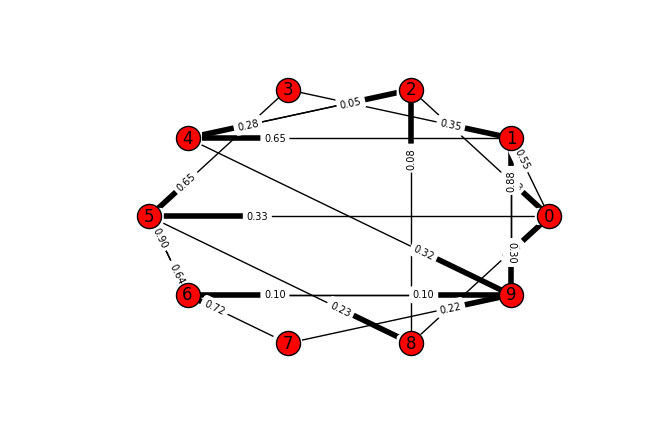

In [145]:
matrix = np.array(HMM_learnedA)
size = matrix[0].size

# Create a graph
DG = nx.DiGraph()
DG.add_nodes_from(range(size))

# Add edges and their weights
for i in range(size):
    for j in range(size):
        weight = matrix.item((i, j))
        if np.abs(weight) >= 0.05 :
            DG.add_edge(i, j, weight=matrix.item((i, j)))

# Draw the graph
pos = nx.circular_layout(DG)
nx.draw(DG, pos, with_labels=True)
edge_labels=dict([((u, v, ), '%.2f'%(d['weight'])) for u, v, d in DG.edges(data=True)])
nx.draw_networkx_edge_labels(DG, pos, edge_labels=edge_labels, label_pos=0.27, font_size=7)
plt.axis('off')
plt.show()